In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import MinCovDet
import numpy as np
import nestle

In [30]:
def localOutlierFactorAnomaly(contamination, fileName):
    data = pd.read_csv(fileName, header=None, names = ["x1","x2","x3"])
    localOutlierFactor = LocalOutlierFactor(contamination = contamination)
    localOutlierFactorAnomaly = localOutlierFactor.fit_predict(data[["x1","x2","x3"]])
    data["Anomaly"] = localOutlierFactorAnomaly
    
    outlierIndexes = np.where(data["Anomaly"] == 1)
    clearIndexes = np.where(data["Anomaly"] == -1)
    clearData = data.drop(clearIndexes[0]).drop("Anomaly", 1)
    outlierData = data.drop(outlierIndexes[0]).drop("Anomaly", 1)
    
    return clearData, outlierData

In [31]:
def ellipticEnvelopAnomaly(contamination, fileName):
    data = pd.read_csv(fileName, header=None, names = ["x1","x2","x3"])
    ellip = EllipticEnvelope(random_state = 0, contamination = contamination).fit(data[["x1","x2","x3"]])
    ellipAnomaly = ellip.predict(data[["x1","x2","x3"]])
    data["Anomaly"] = ellipAnomaly
    
    outlierIndexes = np.where(data["Anomaly"] == 1)
    clearIndexes = np.where(data["Anomaly"] == -1)
    clearData = data.drop(clearIndexes[0]).drop("Anomaly", 1)
    outlierData = data.drop(outlierIndexes[0]).drop("Anomaly", 1)
    
    return clearData, outlierData, ellip.covariance_ * -ellip.offset_, ellip.location_

In [32]:
def iForestAnomaly(contamination, fileName):
    data = pd.read_csv(fileName, header=None, names = ["x1","x2","x3"])
    clf = IsolationForest(random_state=0, contamination = contamination).fit(data[["x1","x2","x3"]])
    clfAnomaly = clf.predict(data[["x1","x2","x3"]])
    data["Anomaly"] = clfAnomaly
    
    outlierIndexes = np.where(data["Anomaly"] == 1)
    clearIndexes = np.where(data["Anomaly"] == -1)
    clearData = data.drop(clearIndexes[0]).drop("Anomaly", 1)
    outlierData = data.drop(outlierIndexes[0]).drop("Anomaly", 1)
    
    return clearData, outlierData

In [33]:
def minCovDet(fileName):
    data = pd.read_csv(fileName, header=None, names = ["x1","x2","x3"])
    minCovDet = MinCovDet(random_state = 0).fit(data[["x1","x2","x3"]])
    
    print(np.linalg.inv(minCovDet.covariance_))
    print(minCovDet.location_)
    
    return minCovDet.covariance_, minCovDet.location_

In [34]:
def drawBox(clearData, outlierData):
    minX1 = clearData["x1"].min()
    maxX1 = clearData["x1"].max()
    
    minX2 = clearData["x2"].min()
    maxX2 = clearData["x2"].max()
    
    minX3 = clearData["x3"].min()
    maxX3 = clearData["x3"].max()
    
    l = maxX1 - minX1
    w = maxX2 - minX2
    h = maxX3 - minX3
    
    center = [(maxX1 + minX1) / 2, (maxX2 + minX2) / 2, (maxX3 + minX3) / 2]
    size = [l, w, h]
    
    ox, oy, oz = center
    l, w, h = size

    x = np.linspace(ox-l/2,ox+l/2,num=10)
    y = np.linspace(oy-w/2,oy+w/2,num=10)
    z = np.linspace(oz-h/2,oz+h/2,num=10)
    x1, z1 = np.meshgrid(x, z)
    y11 = np.ones_like(x1)*(oy-w/2)
    y12 = np.ones_like(x1)*(oy+w/2)
    x2, y2 = np.meshgrid(x, y)
    z21 = np.ones_like(x2)*(oz-h/2)
    z22 = np.ones_like(x2)*(oz+h/2)
    y3, z3 = np.meshgrid(y, z)
    x31 = np.ones_like(y3)*(ox-l/2)
    x32 = np.ones_like(y3)*(ox+l/2)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    # outside surface
    ax.plot_wireframe(x1, y11, z1, rstride=4, cstride=4, color='#2980b9', alpha=1)
    # inside surface
    ax.plot_wireframe(x1, y12, z1, rstride=4, cstride=4, color='#2980b9', alpha=1)
    # bottom surface
    ax.plot_wireframe(x2, y2, z21, rstride=4, cstride=4, color='#2980b9', alpha=1)
    # upper surface
    ax.plot_wireframe(x2, y2, z22, rstride=4, cstride=4, color='#2980b9', alpha=1)
    # left surface
    ax.plot_wireframe(x31, y3, z3, rstride=4, cstride=4, color='#2980b9', alpha=1)
    # right surface
    ax.plot_wireframe(x32, y3, z3, rstride=4, cstride=4, color='#2980b9', alpha=1)
    ax.set_xlabel("X")
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    outliersInBox = outlierData.loc[(outlierData["x1"] <= maxX1) & (outlierData["x1"] >= minX1) &
                                   (outlierData["x2"] <= maxX2) & (outlierData["x2"] >= minX2) &
                                   (outlierData["x3"] <= maxX3) & (outlierData["x3"] >= minX3)]
    
    outliersOutBox = outlierData.loc[(outlierData["x1"] > maxX1) | (outlierData["x1"] < minX1) |
                                   (outlierData["x2"] > maxX2) | (outlierData["x2"] < minX2) |
                                   (outlierData["x3"] > maxX3) | (outlierData["x3"] < minX3)]
    
    ax.scatter(clearData["x1"], clearData["x2"], clearData["x3"])
    ax.scatter(outliersOutBox["x1"], outliersOutBox["x2"], outliersOutBox["x3"], c="orange")
    ax.scatter(outliersInBox["x1"], outliersInBox["x2"], outliersInBox["x3"], c="red")
    plt.show()
    
    print("Size:", size, "\n")
    print("Center:", center)
    

In [35]:
def drawEllipsoid(covarianceMatrix, center, clearData, outlierData):
    """Plot the 3-d Ellipsoid ell on the Axes3D ax."""
    
    #ell = nestle.bounding_ellipsoid(clearData)
    ell = nestle.Ellipsoid(center, np.linalg.inv(covarianceMatrix))
    print("Ellipsoid center: ", ell.ctr, "\n")
    print("Covariance Matrix: ", ell.a)

    fig = plt.figure(figsize=(10., 10.))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(clearData["x1"], clearData["x2"], clearData["x3"], marker='.')
    
    
    # points on unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    z = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    x = np.outer(np.ones_like(u), np.cos(v))

    # transform points to ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j], y[i,j], z[i,j] = ell.ctr + np.dot(ell.axes,
                                                      [x[i,j],y[i,j],z[i,j]])

    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='#2980b9', alpha=0.2)
    values = []
    for index, row in outlierData.iterrows():
        first = np.array(row - center).dot(ell.a)
        second = np.array(first).dot(row - center)
        values.append(second)
        
    outlierData["Value"] = values
    
    outlierDataInEllips = outlierData.loc[outlierData["Value"] <= 1]
    outlierDataOutSideEllips = outlierData.loc[outlierData["Value"] > 1]
    
    ax.scatter(outlierDataInEllips["x1"], outlierDataInEllips["x2"], outlierDataInEllips["x3"], c='red', marker='.')
    ax.scatter(outlierDataOutSideEllips["x1"], outlierDataOutSideEllips["x2"], outlierDataOutSideEllips["x3"], c='orange', marker='.')
 
    fig.tight_layout()
    plt.show()
    
    


In [36]:
def printData(fileName):
    data = pd.read_csv(fileName, header=None, names = ["x1","x2","x3"])
    fig = plt.figure(figsize=(10., 10.))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data["x1"], data["x2"], data["x3"], marker='.')

In [43]:
fileName = "datasetB.csv"

<IPython.core.display.Javascript object>


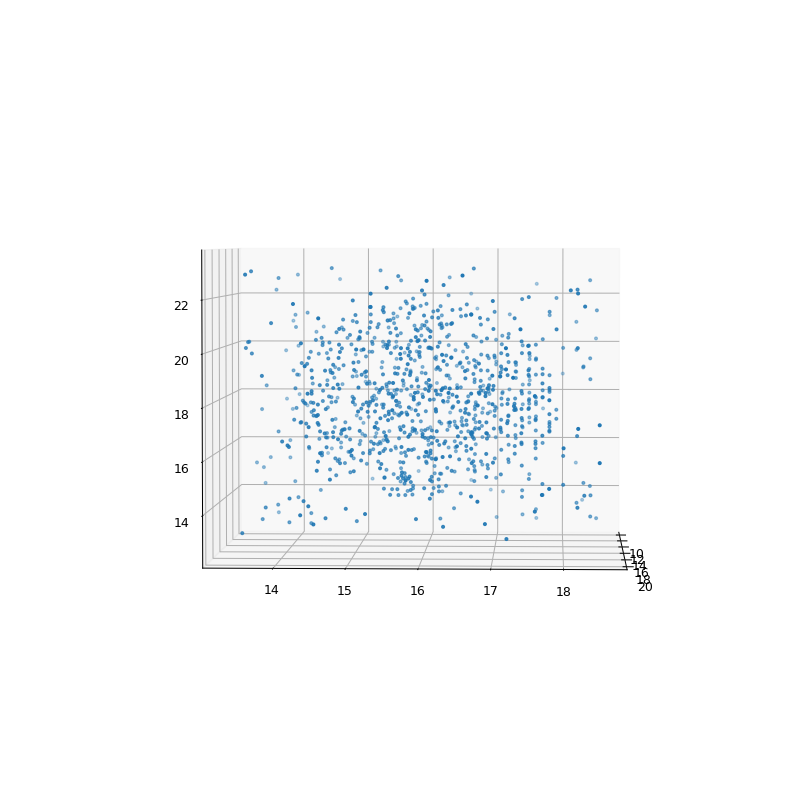

In [44]:
printData(fileName)

In [47]:
contamination = 0.2

C:\Users\ulvif\AppData\Local\Temp/ipykernel_10652/2861667700.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  clearData = data.drop(clearIndexes[0]).drop("Anomaly", 1)
C:\Users\ulvif\AppData\Local\Temp/ipykernel_10652/2861667700.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  outlierData = data.drop(outlierIndexes[0]).drop("Anomaly", 1)


<IPython.core.display.Javascript object>


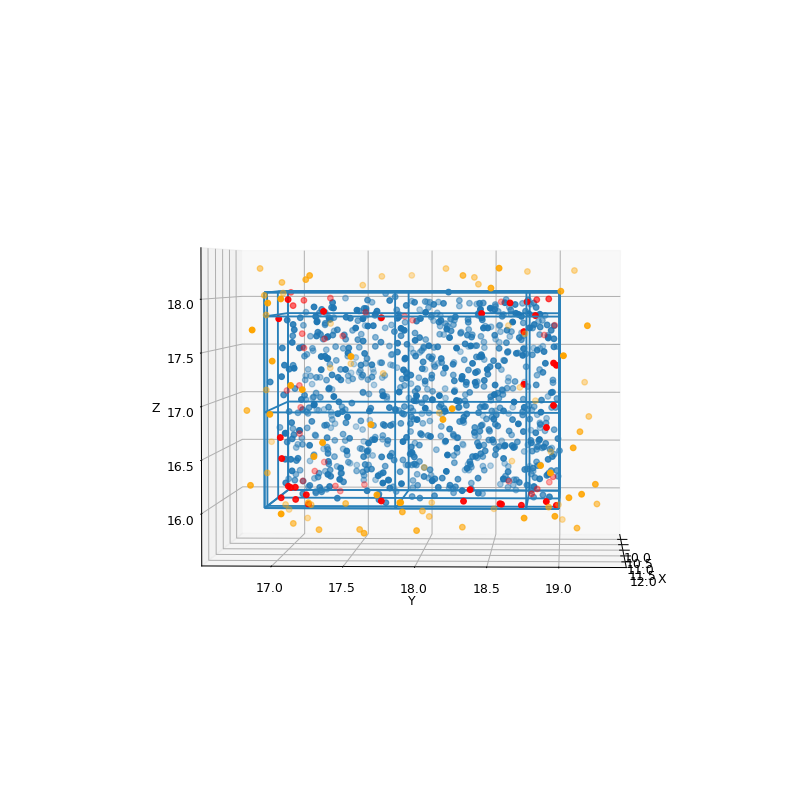

Size: [2.0, 2.09, 2.049999999999997] 

Center: [10.99, 17.955, 17.035]


In [40]:
clearData, outlierData= iForestAnomaly(contamination, fileName)
drawBox(clearData, outlierData)

Ellipsoid center:  [15.08578947 16.02126316 17.86863158] 

Covariance Matrix:  [[ 0.05938748  0.00817596 -0.00274885]
 [ 0.00817596  0.22193665 -0.00801603]
 [-0.00274885 -0.00801603  0.05703614]]


C:\Users\ulvif\AppData\Local\Temp/ipykernel_10652/899892108.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  clearData = data.drop(clearIndexes[0]).drop("Anomaly", 1)
C:\Users\ulvif\AppData\Local\Temp/ipykernel_10652/899892108.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  outlierData = data.drop(outlierIndexes[0]).drop("Anomaly", 1)


<IPython.core.display.Javascript object>


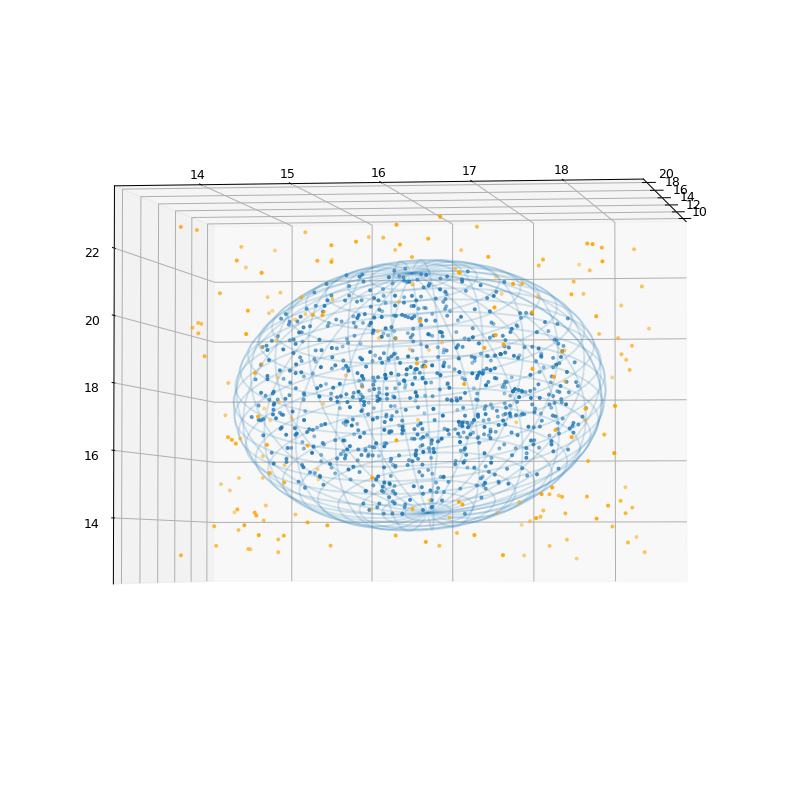

In [48]:
clearData, outlierData, covarianceMatrix, center = ellipticEnvelopAnomaly(contamination, fileName)
drawEllipsoid(covarianceMatrix, center, clearData, outlierData)